# Active Learning Workshop: Beijing - Part I
In this course we will run through a series of exercises that will illustrate how to use different variations of active learning. The goal in active learning it to train models that will use less data in a more intelligent way thereby resulting in increased accuracy.

To get started make sure to download and unzip the [data](https://s3-us-west-1.amazonaws.com/figure-eight-dataset/active_learning_odsc_india/Active_Learning_Workshop_data.zip)

In [47]:
# function to train classifier
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import sys
import shutil
import glob
import random
import matplotlib.pyplot as plt

import tensorflow as tf

EXPERIMENT_RESULTS = None

ROOT_DATA = '/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/'

TRAIN_FLAGS = {
    'background_frequency':0.1,
    'background_volume':0.1,
    'batch_size':20,
    'check_nans':False,
    'clip_duration_ms':10000,
    'data_dir':'', #/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/training_data/supervised
    'data_url':'',
    'eval_step_interval':10,
    'feature_bin_count':40,
    'how_many_training_steps':'1,1',
    'learning_rate':'0.001,0.0001',
    'model_architecture':'conv',
    'preprocess':'mfcc',
    'quantize':False,
    'sample_rate':48000,
    'save_step_interval':10,
    'silence_percentage':0,
    'start_checkpoint':'',
    'summaries_dir':'/tmp/retrain_logs',
    'testing_percentage':5,
    'time_shift_ms':100.0,
    'train_dir':'/tmp/speech_commands_train',
    'unknown_percentage':0,
    'validation_percentage':5,
    'wanted_words':'male,female',
    'window_size_ms':30.0,
    'window_stride_ms':10.0
}

FREEZE_FLAGS = {
    'clip_duration_ms':10000,
    'clip_stride_ms':30,
    'feature_bin_count':40,
    'model_architecture':'conv',
    'output_file':'',       # frozen.pb
    'preprocess':'mfcc',
    'quantize':False,
    'sample_rate':48000,
    'start_checkpoint':'',  # /tmp/speech_commands_train/conv.ckpt-2
    'wanted_words':'male,female',
    'window_size_ms':30.0,
    'window_stride_ms':10.0
}

INFERENCE_FLAGS = {
    'wav_dir':'',      # /Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/female_test
    'graph':'',        # /Users/kvajapey/Documents/CrowdFlower/repos/AI_NEXTCon/frozen.pb
    'labels':'',       # /tmp/speech_commands_train/conv_labels.txt
    'input_name': 'wav_data:0',
    'output_name': 'labels_softmax:0',
    'how_many_labels': 2
}

CLASSIFIER_STATS = {
    'supervised_learning' : {'x':[], 'y':[]}
}


In [37]:
from speech_commands import train
from speech_commands import freeze
from speech_commands import label_wav_dir

def train_model(_):
    tf.reset_default_graph()
    train.main(TRAIN_FLAGS)

def run_training(directory):
    if not directory:
        return "Please input directory with training folders"
    TRAIN_FLAGS['data_dir'] = directory
    #train_model('done')
    tf.app.run(main=train_model, argv=['train.py'])

def freeze_model(_):
    tf.reset_default_graph()
    freeze.main(FREEZE_FLAGS)

def run_freeze(checkpoint, model_out):
    if not checkpoint or not model_out:
        return "Please input the checkpoint to freeze and the name of the output model"
    FREEZE_FLAGS['start_checkpoint'] = checkpoint
    FREEZE_FLAGS['output_file'] = model_out
    freeze_model('done')
    #tf.app.run(main=freeze_model, argv=['freeze.py'])

def inference_model(_):
    global EXPERIMENT_RESULTS
    EXPERIMENT_RESULTS = label_wav_dir.main(INFERENCE_FLAGS)

def run_inference(directory, model, labels):
    if not directory:
        return "Please input the directory with wav files"
    if not model:
        return "Please input the model for inference"
    if not labels:
        return "Please input the file with labels"
    INFERENCE_FLAGS['wav_dir'] = directory
    INFERENCE_FLAGS['graph'] = model
    INFERENCE_FLAGS['labels'] = labels
    print(INFERENCE_FLAGS)
    inference_model('done')
    #tf.app.run(main=inference_model, argv=['label_wav_dir.py'])
    
def test(query_strategy, test_folder, model, labels):
    # run inferences on male and female test sets
    male_audio = test_folder + '/male'
    female_audio = test_folder + '/female'
    total_male = 0
    total_female = 0
    correct_male = 0
    incorrect_male = 0
    correct_female = 0
    incorrect_female = 0
    # male test
    run_inference(male_audio, model, labels)
    for row in EXPERIMENT_RESULTS:
        total_male += 1
        if 'male' in row and 'female' in row:
            if row['male'] > row['female']:
                correct_male += 1
            else:
                incorrect_male += 1
        else:
            if 'male' in row:
                correct_male += 1
            elif 'female' in row:
                incorrect_male += 1
    # female test
    run_inference(female_audio, model, labels)
    for row in EXPERIMENT_RESULTS:
        total_female += 1
        if 'male' in row and 'female' in row:
            if row['male'] > row['female']:
                incorrect_female += 1
            else:
                correct_female += 1
        else:
            if 'male' in row:
                incorrect_female += 1
            elif 'female' in row:
                correct_female += 1
    total = total_male + total_female
    total_correct = correct_male + correct_female
    total_incorrect = incorrect_male + incorrect_female
    tpr = total_correct / total
    fpr = total_incorrect / total
    qs_train_size = 0
    male_count = len(glob.glob(ROOT_DATA + query_strategy + '/train/male/*.wav'))
    female_count = len(glob.glob(ROOT_DATA + query_strategy + '/train/female/*.wav'))
    qs_train_size = male_count + female_count
    x = qs_train_size
    y = tpr
    if query_strategy in CLASSIFIER_STATS:
        CLASSIFIER_STATS[query_strategy]['x'].append(x)
        CLASSIFIER_STATS[query_strategy]['y'].append(y)
    else:
        CLASSIFIER_STATS[query_strategy] = {'x':[x], 'y':[y]}
    return 'Accuracy is ' + str(tpr) + '%'
    

In [3]:
# run training of the model
#run_training('/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/training_data/supervised')

In [4]:
# freeze the model
#run_freeze('/tmp/speech_commands_train/conv.ckpt-2', 'superviser.pb')

In [5]:
# run inferences
#run_inference('/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/test/male', 'superviser.pb', '/tmp/speech_commands_train/conv_labels.txt')

In [48]:
# run test
#test('/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection/test', 'superviser.pb', '/tmp/speech_commands_train/conv_labels.txt')

In [10]:
"""
Helper functions for Active Learning Workshop
"""

def prep_query_strategy(name):
    qs_folder = ROOT_DATA + name
    if not os.path.exists(qs_folder):
        os.mkdir(qs_folder)
    unlabeled = qs_folder + '/unlabeled'
    train = qs_folder + '/train'
    male = train + '/male'
    female = train + '/female'
    if not os.path.exists(unlabeled):
        os.mkdir(unlabeled)
    if not os.path.exists(train):
        os.mkdir(train)
    if not os.path.exists(male):
        os.mkdir(male)
    if not os.path.exists(female):
        os.mkdir(female)
    files = glob.glob(ROOT_DATA + '/unlabeled/*')
    for f in files:
        fname = f.split('/')[-1]
        new_loc = unlabeled + '/' + fname
        if not os.path.exists(new_loc):
            shutil.copyfile(f, new_loc)
    
    
def random_seed_data(query_strategy):
    qs_folder = ROOT_DATA + query_strategy
    if not os.path.exists(qs_folder):
        prep_query_strategy(query_strategy)
    unlabeled = qs_folder + '/unlabeled'
    files = glob.glob(unlabeled + '/*.wav')
    seed_data = random.sample(files, 100)
    male = 0
    female = 0
    train = qs_folder + '/train'
    for s in seed_data:
        fn = s.split('/')[-1]
        mf = fn.split('_')[0]

        if mf == 'male':
            dest = train + '/male/' + fn
            male += 1
        else:
            dest = train + '/female/' + fn
            female += 1
        shutil.move(s, dest)
    print('Male examples: ' + str(male))
    print('Female examples: ' + str(female))

# Exercise 0: Supervised Learning
In the exercise we will use basic supervised learning to update the classifier. This works by selecting a random set of data, labeling that data, and using that to train each class of the classifier.

First, we will test the new classifier that we created. Once we have a baseline accuracy we will use the `supervised_learning()` function to get new batches of data for each class in the form of .zip files which we will use to update each class of the Watson classifier.

Use the function below to automatically select random data, get the labels, and create the zip files required to add to each class of the Watson classifier.

In [52]:
"""
This cell initialized the data for supervised learning strategy
"""
prep_query_strategy('supervised_learning')
random_seed_data('supervised_learning')

Male examples: 45
Female examples: 55


In [11]:
"""
This cell trains the first model for supervised learning
"""
run_training(ROOT_DATA + 'supervised_learning/train')

INFO:tensorflow:Training from step: 1 
INFO:tensorflow:Step #1: rate 0.001000, accuracy 5.0%, cross entropy 1.679098
INFO:tensorflow:Step #2: rate 0.000100, accuracy 50.0%, cross entropy 1.177976
INFO:tensorflow:Confusion Matrix:
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 2]]
INFO:tensorflow:Step 2: Validation accuracy = 66.7% (N=3)
INFO:tensorflow:Saving to "/tmp/speech_commands_train/conv.ckpt-2"
INFO:tensorflow:set_size=7
INFO:tensorflow:Confusion Matrix:
 [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 1 4]]
INFO:tensorflow:Final test accuracy = 57.1% (N=7)


SystemExit: 

/Users/kvajapey/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
"""
This cell creates the first graph for supervised learning
"""
run_freeze('/tmp/speech_commands_train/conv.ckpt-2', 'supervised_1.pb')

{'clip_duration_ms': 10000, 'clip_stride_ms': 30, 'feature_bin_count': 40, 'model_architecture': 'conv', 'output_file': 'supervised_1.pb', 'preprocess': 'mfcc', 'quantize': False, 'sample_rate': 48000, 'start_checkpoint': '/tmp/speech_commands_train/conv.ckpt-2', 'wanted_words': 'male,female', 'window_size_ms': 30.0, 'window_stride_ms': 10.0}
INFO:tensorflow:Restoring parameters from /tmp/speech_commands_train/conv.ckpt-2
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.
INFO:tensorflow:Saved frozen graph to supervised_1.pb


In [24]:
"""
This cell tests the accuracy of the first supervised learning model
"""
test('supervised_learning', ROOT_DATA + '/test', 'supervised_1.pb', '/tmp/speech_commands_train/conv_labels.txt')

{'wav_dir': '/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection//test/male', 'graph': 'supervised_1.pb', 'labels': '/tmp/speech_commands_train/conv_labels.txt', 'input_name': 'wav_data:0', 'output_name': 'labels_softmax:0', 'how_many_labels': 2}
{'wav_dir': '/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection//test/female', 'graph': 'supervised_1.pb', 'labels': '/tmp/speech_commands_train/conv_labels.txt', 'input_name': 'wav_data:0', 'output_name': 'labels_softmax:0', 'how_many_labels': 2}


'Accuracy is 0.45897435897435895%'

{'supervised_learning': [0.45897435897435895, 0.45897435897435895]}


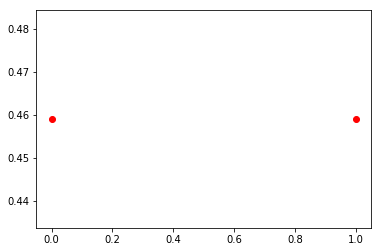

In [25]:
print(CLASSIFIER_STATS)
plt.plot(CLASSIFIER_STATS['supervised_learning'], 'ro')
plt.show()

Next you will run a series of supervised learning steps. Here you will run the following code to produce class zips and add these to your first classifier. As you complete each round of training, you should run the test code to see how the model accuracy improves over time.

In [50]:
"""
description: function for supervised learning.
Select random images and label all images
"""
def supervised_learning_train():
    random_seed_data('supervised_learning')
    run_training(ROOT_DATA + 'supervised_learning/train')

def supervised_learning_run():
    run_freeze('/tmp/speech_commands_train/conv.ckpt-2', 'supervised_1.pb')
    test('supervised_learning', ROOT_DATA + '/test', 'supervised_1.pb', '/tmp/speech_commands_train/conv_labels.txt')
    plt.plot(CLASSIFIER_STATS['supervised_learning']['x'], CLASSIFIER_STATS['supervised_learning']['y'],'ro')
    plt.show()
    



In [53]:
supervised_learning_train()

Male examples: 50
Female examples: 50


/Users/kvajapey/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Training from step: 1 
INFO:tensorflow:Step #1: rate 0.001000, accuracy 45.0%, cross entropy 1.671158
INFO:tensorflow:Step #2: rate 0.000100, accuracy 55.0%, cross entropy 1.195272
INFO:tensorflow:Confusion Matrix:
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  3  7]
 [ 0  0  3 11]]
INFO:tensorflow:Step 2: Validation accuracy = 58.3% (N=24)
INFO:tensorflow:Saving to "/tmp/speech_commands_train/conv.ckpt-2"
INFO:tensorflow:set_size=33
INFO:tensorflow:Confusion Matrix:
 [[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  2 13]
 [ 0  0  5 13]]
INFO:tensorflow:Final test accuracy = 45.5% (N=33)


SystemExit: 

/Users/kvajapey/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


{'clip_duration_ms': 10000, 'clip_stride_ms': 30, 'feature_bin_count': 40, 'model_architecture': 'conv', 'output_file': 'supervised_1.pb', 'preprocess': 'mfcc', 'quantize': False, 'sample_rate': 48000, 'start_checkpoint': '/tmp/speech_commands_train/conv.ckpt-2', 'wanted_words': 'male,female', 'window_size_ms': 30.0, 'window_stride_ms': 10.0}
INFO:tensorflow:Restoring parameters from /tmp/speech_commands_train/conv.ckpt-2
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.


/Users/kvajapey/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Saved frozen graph to supervised_1.pb
{'wav_dir': '/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection//test/male', 'graph': 'supervised_1.pb', 'labels': '/tmp/speech_commands_train/conv_labels.txt', 'input_name': 'wav_data:0', 'output_name': 'labels_softmax:0', 'how_many_labels': 2}
{'wav_dir': '/Users/kvajapey/Documents/CrowdFlower/Conferences/Beijing/workshop/data/gender_detection//test/female', 'graph': 'supervised_1.pb', 'labels': '/tmp/speech_commands_train/conv_labels.txt', 'input_name': 'wav_data:0', 'output_name': 'labels_softmax:0', 'how_many_labels': 2}


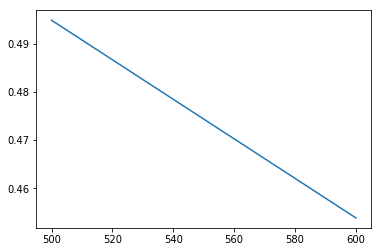

In [54]:
supervised_learning_run()

{'supervised_learning': {'x': [500, 500], 'y': [0.4948717948717949, 0.4948717948717949]}}


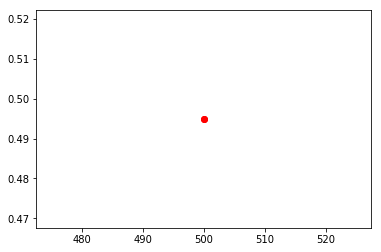

In [52]:
print(CLASSIFIER_STATS)
plt.plot(CLASSIFIER_STATS['supervised_learning']['x'], CLASSIFIER_STATS['supervised_learning']['y'],'ro')
plt.show()


#### Task: Run iterations of supervised learning and plot the accuracy of the model as more data is added

In [166]:
# TODO: Write the code to run additional tests after each round of training
# HINT: This is the same code used above to complete the first round of training

# Exercise 1: Confidence Sampling
In this exercise you will use confidence-based sampling. The goal is to create a query method that will rapidly increase the accuracy of your model with as little data as possible.

The idea of confidence sampling is that you are making inferences on your initial classifier. Based on the confidence of these inferences you want to intelligently select which examples you want to add directly to your model and which samples you want to explicitly label.

#### Task: Create a function that uses confidence sampling to select which examples should be manually labeled. Once these have been selected run them through the label function and create batches to be added to the classifier.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

Running inferences for classifier qd_2_2048362238...
Running inference for 1_70.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.883}]}], 'image': './test_images/1_70.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_71.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.906}]}], 'image': './test_images/1_71.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_72.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.857}]}], 'image': './test_images/1_72.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_73.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.777}]}], 'image': './test_imag

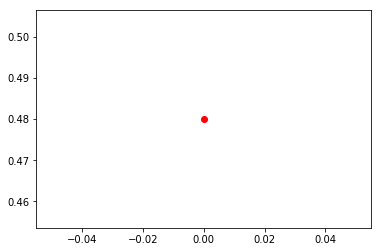

In [79]:
"""
Run preliminary test of classifier to get baseline accuracy
"""
test_classifier('c1', WATSON_CLASSIFIER_ID_2)
plt.plot(classifier_stats['c1'], 'ro')
plt.show()

In [91]:
"""
function: basic_confidence_sampling
threshold (float): float between 0 and 1 for threshold to label images
"""
def confidence_sampling():
    images = choose_images(100) # You can select the number of images you want to test
    inferences = run_inferences(images, IMAGE_DIRECTORY, WATSON_CLASSIFIER_ID_2)
    to_label = []
    for image in inferences:
        confidence = inferences[image]['confidence']
        if confidence < 0.8:
            to_label.append(image)
    print(to_label)
    labels = label_images_with_ground_truth(to_label)
    # TODO: fill in your confidence query method here.
    # Based on the confidence select which samples you want to label
    # and then create the required zip files for those images and add them
    # to your model
    
    lqz = create_zip(labels['low_quality'], 'low_quality')
    mqz = create_zip(labels['medium_quality'], 'medium_quality')
    hqz = create_zip(labels['high_quality'], 'high_quality')



In [92]:
confidence_sampling()

Running inferences for classifier qd_2_2048362238...
Running inference for 3_5416.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.809}]}], 'image': './images/3_5416.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_3326.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.786}]}], 'image': './images/3_3326.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 2_924.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.688}]}], 'image': './images/2_924.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_1204.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'high_quality', 'score': 0.816}]}], 'image': './image

{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.832}]}], 'image': './images/3_5389.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 4_6787.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'high_quality', 'score': 0.895}]}], 'image': './images/4_6787.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_1267.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.774}]}], 'image': './images/3_1267.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_4630.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.739}]}], 'image': './images/3_4630.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 4

{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.817}]}], 'image': './images/3_3717.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 2_240.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.826}]}], 'image': './images/2_240.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_2874.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.528}]}], 'image': './images/3_2874.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 2_543.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'high_quality', 'score': 0.71}]}], 'image': './images/2_543.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_5428.jpg
{

{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.723}]}], 'image': './images/4_6593.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 2_449.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.891}]}], 'image': './images/2_449.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 3_1133.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.772}]}], 'image': './images/3_1133.jpg'}], 'images_processed': 1, 'custom_classes': 3}
['3_3326.jpg', '2_924.jpg', '4_6243.jpg', '3_5292.jpg', '3_5202.jpg', '2_950.jpg', '3_1675.jpg', '3_3751.jpg', '3_5443.jpg', '4_6864.jpg', '3_1267.jpg', '3_4630.jpg', '4_7127.jpg', '3_4370.jpg', '2_996.jpg', '2_571.jpg', '3_4440.jpg', '3_3943.jpg', '2_979.jpg', '3_1390.jpg', '3_519

Running inferences for classifier qd_2_2048362238...
Running inference for 1_70.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.862}]}], 'image': './test_images/1_70.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_71.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.879}]}], 'image': './test_images/1_71.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_72.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'low_quality', 'score': 0.872}]}], 'image': './test_images/1_72.jpg'}], 'images_processed': 1, 'custom_classes': 3}
Running inference for 1_73.jpg
{'images': [{'classifiers': [{'classifier_id': 'qd_2_2048362238', 'name': 'qd_2', 'classes': [{'class': 'medium_quality', 'score': 0.758}]}], 'image': './test_imag

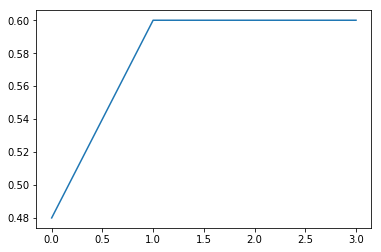

In [98]:
"""
Use this code to test your classifier after each round of confidence sampling and plot your results
"""
test_classifier('c1', WATSON_CLASSIFIER_ID_2)
plt.plot(classifier_stats['c1'])
plt.show()

# Exercise 2: Margin Sampling
In this exercise we will use margin sampling to train a third classifier. In margin sampling we want to look at the various predictions provided by the classifier and determine what threshold should be set in order to label the least number of images while getting the most performance gains out of the classifier.

An example of margin sampling could be to manually label any item where the top two predictions are within 20% confidence of one another.

For example:

`
Image 1: {'high_quality': 0.77, 'medium_quality': 0.73, 'low_quality': 0.01}
`

Here we can see that "high_quality" and "medium_quality" are very close and we should get an explicit label to make it apparent which one we should use.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [ ]:
"""
Run preliminary test of classifier to get baseline accuracy
"""
test_classifier('c2', WATSON_CLASSIFIER_ID_3)
plt.plot(classifier_stats['c2'], 'ro')
plt.show()

In [167]:
def margin_sampling(threshold):
    images = choose_images(20) # You can select the number of images you want to test
    inferences = run_inferences(images, IMAGE_DIRECTORY)
    for image in inferences:
        # TODO: fill in your margin sampling method here
        # Based on the margin of confidence in the resulting predictions
        # you should decide which examples you want to manually label
        # and then create the required zips with those images

In [ ]:
"""
Write your code here to test your classifier after each round of training
This should be WATSON_CLASSIFIER_ID_3 and classifier_stats['c2']
HINT: This is similar to the test and plot code bits used in previous exercises
"""

# Exercise 3: Query by Committee
In this exercise we want to create a query by committee strategy. You have a couple options.

1. Use the three classifiers you trained above as your "committee" and update all classifiers
2. Delete the three classifiers and create three new ones to be used for the query by committee.

Three different intializer datasets are provided so feel free to use those to create your initial classifiers.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [99]:
def query_by_committee():
    model_1 = m1
    model_2 = m2
    model_3 = m3
    images = choose_images(20)
    for image in images:
        inf1 = model_1(image) # inf1 = 0.7 (low)
        inf2 = model_2(image) # inf2 = 0.67 (low)
        inf3 = model_3(image) # inf3 = 0.5 (medium)
        # option 1
        if class(inf1) == class(inf2) == class(inf3):
            continue
        else:
            to_label.append(image)
        # option 2
        if class(inf1) == class(inf2) == class(inf3):
            if conf(inf1 || inf2 || inf3) < 0.7:
                to_label.append(image)
            else:
                continue
    # TODO: Create a query by committee function.
    # Like before the goal should be to create three zip files in this
    # function that will be the training data to be added to the classifier
    # Also after each round of training we want to run our test to see how
    # the accuracy is improving.

In [ ]:
"""
Write your code here to test your classifier after each round of training
This should be WATSON_CLASSIFIER_ID_3 and classifier_stats['c3']
HINT: This is similar to the test and plot code bits used in previous exercises
"""

# Exercise 4: Build your own
In this exercise you will build your own query function using any of the methods used previous. This is where you should get creative and think about the best query strategy to train a model with the least amount of data.

#### NOTE: Make sure to run a preliminary test to get a baseline accuracy of your model

In [169]:
def my_strategy():
    pass
    # TODO: Fill in your custom query function here

In [170]:
"""
Write your code here to test your classifier after each round of training
HINT: This is similar to the test and plot code bits used in previous exercises
"""

'\nWrite your code here to test your classifier after each round of training\nHINT: This is similar to the test and plot code bits used in previous exercises\n'